In [1]:
# 1 FILTER DATAFRAME USING THE SAME BOUNDING BOX YOU HAVE USED FOR QUERYING THE API
# 2 FETCH THE IMAGE IDS IN THE SAME BOUNDING BOX WITH MAPILLARY
# 3 MATCH THE IMAGE IDS WITH THE EDGE IDS:
#### - ADD EXTRA POINTS BETWEEN EVERY EDGE START AND END (edge points) 
#### - Construct A BALL TREE WITH THE EDGE POINTS (https://stackoverflow.com/questions/56862277/interpreting-sklearn-haversine-outputs-to-kilometers)
#### - Query the Ball tree using the simage points (for each image, find the closest point)
#### - Remove matches such that the distance is larger than 50 meters
#### - Build a dictionary image_id --> edge_id

In [2]:
import geopandas as gpd
import matplotlib.pylab as plt
from shapely.geometry import Polygon
import numpy as np
import itertools
from operator import itemgetter
import pandas as pd
from shapely.geometry import Point
from scipy.spatial import cKDTree
from shapely.geometry import Point, LineString
import requests as rq
import json
from sklearn.neighbors import BallTree
from dbfread import DBF

In [3]:
#Load shapefile

my_shapefile_path = "/home/s214613/data/all_edges_monthly_jan_2022-dec_2022_ped/7f42d69dd7bd00b04081b9cbd0d05ab4e5f87353dcd7364c34b8e7c74d42109d-1676891223740.shp"
my_shp = gpd.read_file(my_shapefile_path)
#print(my_shp)

In [4]:
#Access to Mapillary API

clienttoken = 
clientsecret = 

#URL for getting only images within the chosen boundaries
url = f"https://graph.mapillary.com/images?access_token={clienttoken}&fields=id,computed_geometry&bbox=12.539467,55.660144,12.563714,55.675971"

response = rq.get(url)

rqcon = response.content

#Decode in order to get rid og bytestring 
deco = rqcon.decode()

result = json.loads(deco)
images = list(result.values())[0]

#Loop to get list of coordinates and ID's 
#Not all images has coordinates so the try/except only gets the ID's which has coordinates
coor = []
ID = []
for i in range(0,len(images)):
    try:
        coord = images[i]["computed_geometry"]["coordinates"]
        coor.append(coord)
        id = str(images[i]["id"])
        ID.append(id)
    except KeyError:
        continue
#print(coor[0][0])
#print(ID)
new_coor =[] 
for i in range(0,len(coor)):
    vupti = coor[i][0]




#Get coordinates as Shapely Points 
points = []

for i in range(0,len(coor)):
    point = Point(coor[i])
    points.append(point)

#print(points)

#Check if Id and points are the same length
#print(len(ID))
#print(len(points))


#Create geopandas dataframe from ID's and points
dataframepoints = {"ID": ID, "geometry": points}
df_points = gpd.GeoDataFrame(dataframepoints)
num_images = len(df_points)

print(df_points)


                    ID                   geometry
0     1311631602993151  POINT (12.55836 55.66978)
1     1354825674876910  POINT (12.56331 55.66404)
2     1427835547630422  POINT (12.54490 55.66858)
3     1690590734475734  POINT (12.56112 55.67350)
4     2772609563051507  POINT (12.54137 55.66240)
...                ...                        ...
1978  1351079338610005  POINT (12.56251 55.67498)
1979  1313716112380241  POINT (12.54521 55.67156)
1980  2304411526362023  POINT (12.56241 55.67416)
1981  2930037597142243  POINT (12.56322 55.66781)
1982  3072731873004814  POINT (12.56134 55.66031)

[1983 rows x 2 columns]


In [5]:
#Set boundaries
bound = Polygon([(12.539467, 55.660144), (12.539467, 55.675971),(12.563714, 55.675971), (12.563714, 55.660144)])

#Find the values from the shapefile that is within the boundaries
TF = my_shp.within(bound)


edges_within_bound_index = TF[TF].index

geo_tag = my_shp["geometry"][TF.values]


emp_list = []
for i in range(0,len(edges_within_bound_index)):
    segment_list = []
    for i in list(geo_tag.iloc[i].coords):
        segment_list.append(list(i))
    #if 2 < len(segment_list):
    #    continue
    emp_list.append(segment_list)



#Create dataframe 
data1 = {"ID": my_shp["edgeUID"][TF.values], "geometry": geo_tag}
df_lines = gpd.GeoDataFrame(data1)
print(df_lines)


#df_lines = gpd.GeoDataFrame(TF)



               ID                                           geometry
47      174472823  LINESTRING (12.54255 55.66452, 12.54272 55.66479)
188     174472925  LINESTRING (12.54329 55.66718, 12.54352 55.667...
515     174477311  LINESTRING (12.56242 55.67385, 12.56234 55.67394)
845     174474161  LINESTRING (12.54380 55.67105, 12.54376 55.67109)
849     174477032  LINESTRING (12.56357 55.67126, 12.56361 55.67128)
...           ...                                                ...
301660  174474898  LINESTRING (12.54812 55.66269, 12.54809 55.66274)
301676  174475046  LINESTRING (12.55384 55.66429, 12.55399 55.66431)
301682  174475045  LINESTRING (12.55396 55.66422, 12.55400 55.664...
301756  174475042  LINESTRING (12.55399 55.66431, 12.55398 55.664...
301808  174475039  LINESTRING (12.55413 55.66424, 12.55396 55.66422)

[2442 rows x 2 columns]


<Axes: >

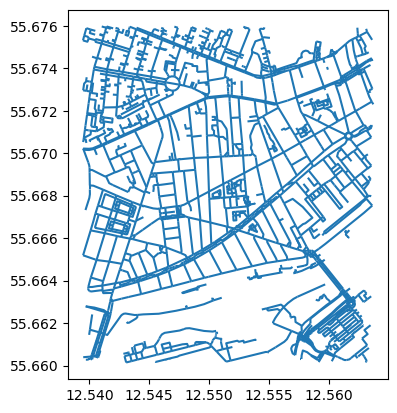

In [6]:

df_lines["geometry"].plot()

/tmp/ipykernel_132211/3281745053.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_lines["geometry"].buffer(0.0001, cap_style = 2).plot(ax=ax,alpha=0.5)   #With Buffer


<Axes: >

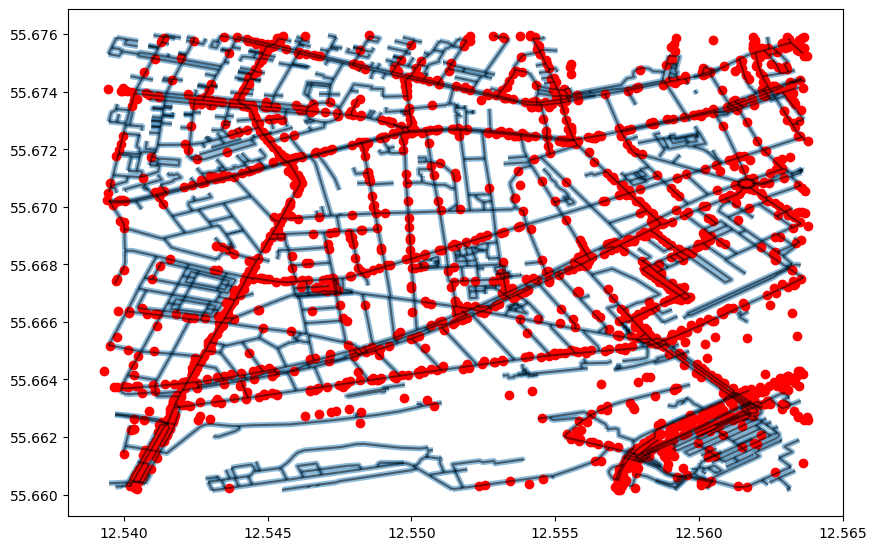

In [7]:
fig, ax = plt.subplots(figsize = (10,10))
df_lines["geometry"].buffer(0.0001, cap_style = 2).plot(ax=ax,alpha=0.5)   #With Buffer
#df_lines["geometry"].plot(ax=ax,alpha=0.5)  #W/o buffer
df_lines["geometry"].plot(ax=ax,alpha=0.5,color = "k")
df_points["geometry"].plot(ax=ax,color = "r")



## Non-assigned Pictures

/tmp/ipykernel_132211/898194467.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_polygons["geometry"] = df_polygons["geometry"].buffer(0.0001, cap_style = 2)
/tmp/ipykernel_132211/898194467.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_lines["geometry"].buffer(0.0001, cap_style = 2).plot(ax=ax,alpha=0.5)


299


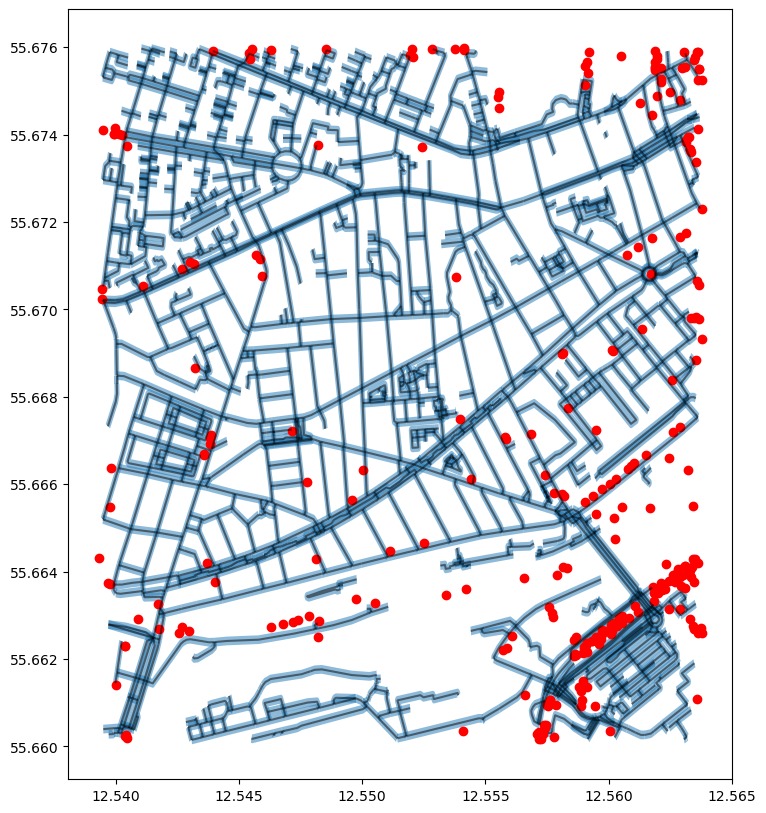

In [8]:
df_polygons = df_lines.copy()
df_polygons.crs = df_lines.crs
df_points.crs = df_lines.crs
df_polygons["geometry"] = df_polygons["geometry"].buffer(0.0001, cap_style = 2)

pointInPoly = gpd.sjoin(df_points, df_polygons, how='left',predicate='within') 

fig, ax = plt.subplots(figsize = (10,10))
df_lines["geometry"].buffer(0.0001, cap_style = 2).plot(ax=ax,alpha=0.5)
df_lines["geometry"].plot(ax=ax,alpha=0.5,color = "k")
pointInPoly[pointInPoly['index_right'].isna()].plot(ax=ax,color = "r")

print(len(pointInPoly[pointInPoly['index_right'].isna()]))


In [9]:
pointInPoly

,ID_left,geometry,index_right,ID_right
0,1311631602993151,POINT (12.55836 55.66978),19813.0,174476799.0
1,1354825674876910,POINT (12.56331 55.66404),NaN,NaN
2,1427835547630422,POINT (12.54490 55.66858),148228.0,174474030.0
3,1690590734475734,POINT (12.56112 55.67350),145631.0,174477284.0
3,1690590734475734,POINT (12.56112 55.67350),169182.0,174477275.0
...,...,...,...,...
1980,2304411526362023,POINT (12.56241 55.67416),26875.0,174477319.0
1980,2304411526362023,POINT (12.56241 55.67416),32435.0,174477314.0
1980,2304411526362023,POINT (12.56241 55.67416),191620.0,174477318.0
1981,2930037597142243,POINT (12.56322 55.66781),297482.0,174475848.0


<Axes: >

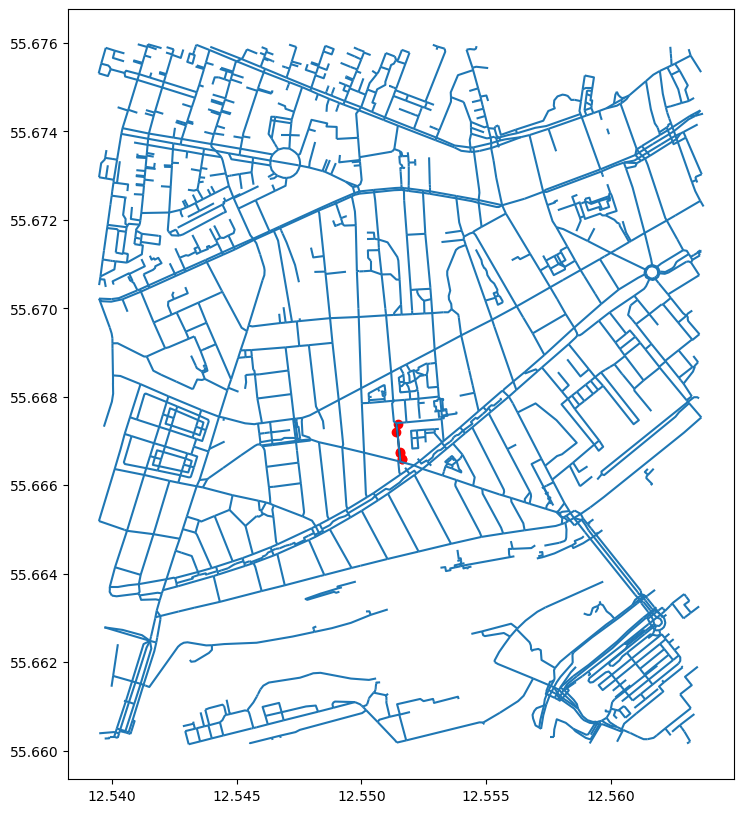

In [10]:
fig, ax = plt.subplots(figsize = (10,10))
test = pointInPoly[pointInPoly.ID_right==174475028].copy()
df_lines[df_lines.ID==174475028].plot(ax=ax, color = "k")
df_lines.plot(ax=ax)
test["geometry"].plot(color = "r",ax=ax)

(55.660144, 55.675971)

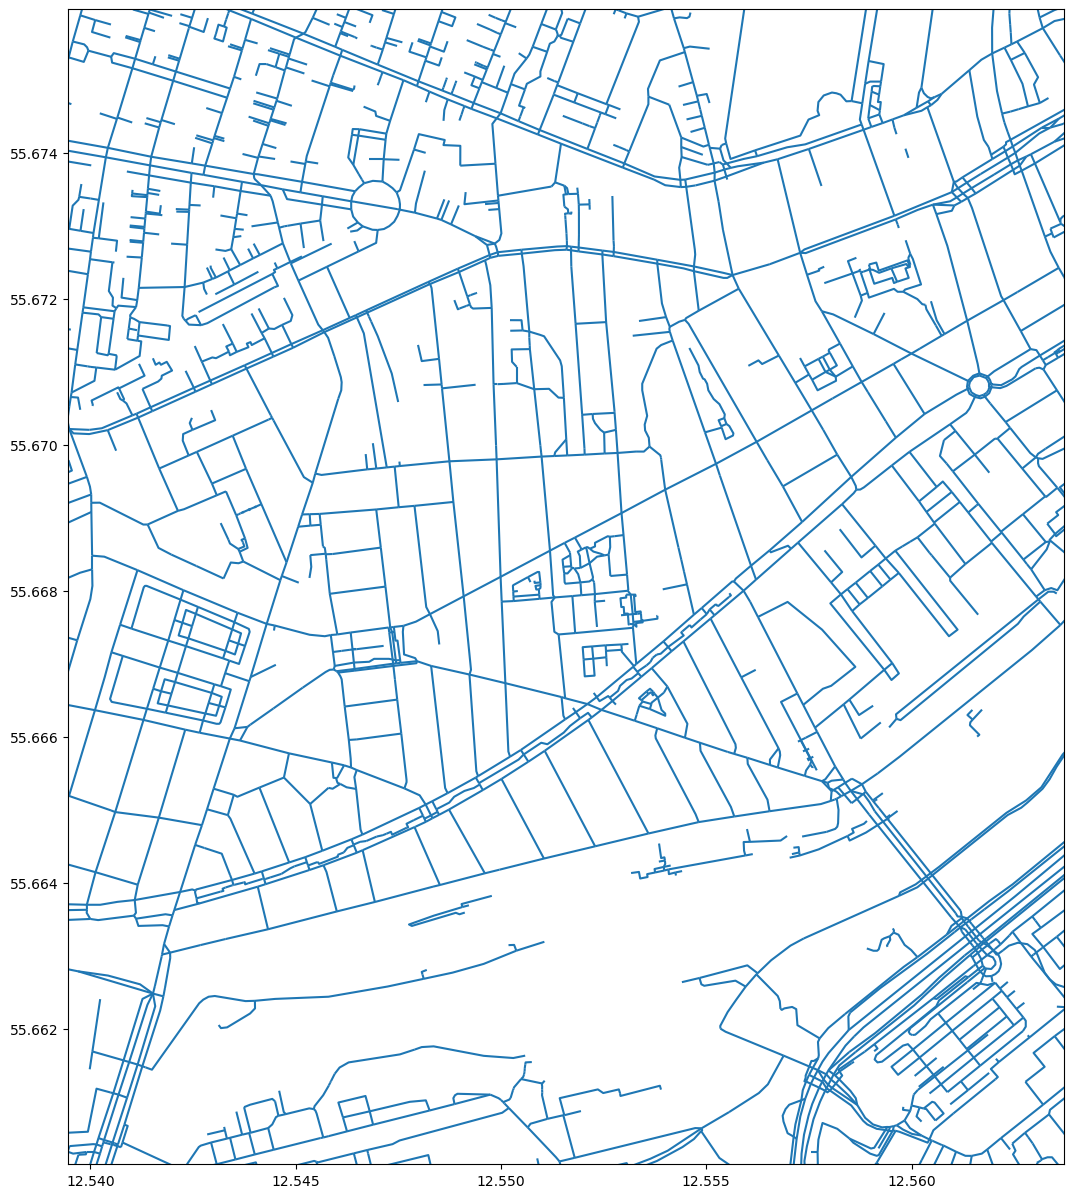

In [11]:
fig, ax = plt.subplots(1, 1, figsize = (15,15))
my_shp.plot(ax = ax)

ax.set_xlim(12.539467, 12.563714)
ax.set_ylim(55.660144, 55.675971)

In [12]:
#Shapefile gives edgeUID, osmId and geometry 
shp = "/home/s214613/data/all_edges_monthly_jan_2022-dec_2022_ped/7f42d69dd7bd00b04081b9cbd0d05ab4e5f87353dcd7364c34b8e7c74d42109d-1676891223740.shp"
strava_shape = gpd.read_file(shp)
#print(strava_shape)

#csv-file gives edge_uid, actitivity type, date, total_trip_count etc. 
strava_csv = pd.read_csv("/home/s214613/data/all_edges_monthly_jan_2022-dec_2022_ped/7f42d69dd7bd00b04081b9cbd0d05ab4e5f87353dcd7364c34b8e7c74d42109d-1676891223740.csv")
#print(strava_csv)

#dbf-file gives edgeUID and osmId 
dbf = DBF('/home/s214613/data/all_edges_monthly_jan_2022-dec_2022_ped/7f42d69dd7bd00b04081b9cbd0d05ab4e5f87353dcd7364c34b8e7c74d42109d-1676891223740.dbf')
frame = pd.DataFrame(iter(dbf))
#print(frame)

#textfile ???
file1 = open("/home/s214613/data/all_edges_monthly_jan_2022-dec_2022_ped/7f42d69dd7bd00b04081b9cbd0d05ab4e5f87353dcd7364c34b8e7c74d42109d-1676891223740.txt","r")
#print(file1)

In [13]:

#print(strava_csv)

csv_df = {"ID": strava_csv["edge_uid"], "Activity": strava_csv["total_trip_count"]}
# "Month": strava_csv["month"]
csv_df = pd.DataFrame(data=csv_df)
csv_df = csv_df.dropna(subset=["ID"])
csv_df["Summed activity"] = csv_df.groupby("ID")["Activity"].transform("sum")
collapsed_df = csv_df.drop_duplicates(subset=["ID"], keep="first")
filtered_df = collapsed_df[collapsed_df["ID"].isin(df_lines["ID"])]

activity_df = pd.DataFrame({"ID": filtered_df["ID"], "Activity": filtered_df["Summed activity"]})

list_ID_ac = activity_df["ID"].tolist()
list_ID_line = df_lines["ID"].tolist()
print((len(list_ID_ac),len(list_ID_line)))

print(activity_df)


(1901, 2442)
                ID  Activity
3552     174476152      1260
4284     174476138       725
5205     174472857     11885
5217     174475361     11190
6086     174474204      5855
...            ...       ...
1662088  174475728     11890
1662100  174476604     10050
1664757  174474907       565
1665491  174474571      4670
1665515  174476242      2935

[1901 rows x 2 columns]


In [14]:
merged_df = pd.merge(pointInPoly, activity_df, left_on="ID_right", right_on="ID")
merged_df

,ID_left,geometry,index_right,ID_right,ID,Activity
0,1311631602993151,POINT (12.55836 55.66978),19813.0,174476799.0,174476799,6930
1,1710984795982717,POINT (12.55839 55.66976),19813.0,174476799.0,174476799,6930
2,2857959371130767,POINT (12.55838 55.66969),19813.0,174476799.0,174476799,6930
3,1427835547630422,POINT (12.54490 55.66858),148228.0,174474030.0,174474030,19235
4,5572480562775479,POINT (12.54503 55.66878),148228.0,174474030.0,174474030,19235
...,...,...,...,...,...,...
2451,1270399660197693,POINT (12.54681 55.66965),193773.0,174475918.0,174475918,1275
2452,2568955033398262,POINT (12.54980 55.67114),73674.0,174476020.0,174476020,4270
2453,1232451524259072,POINT (12.54990 55.67331),15650.0,174476305.0,174476305,11990
2454,1232451524259072,POINT (12.54990 55.67331),177845.0,174476302.0,174476302,15


In [15]:
isnull = merged_df.index[merged_df["Activity"].isnull()].tolist()

isnull

[]

In [16]:
'''
result = merged_df.drop_duplicates(['ID_left'],keep='first')
result
reset = result.reset_index()
reset.pop("index")
reset
#dataframe2 = reset.rename(columns = {"ID_left": "Image ID","geometry": "Image coordinate","index_right": "Segment index","ID_right": "Segment ID", "ID": "Segment ID","Activity": "Activity"}, inplace=True)
#print(dataframe2)
'''

'\nresult = merged_df.drop_duplicates([\'ID_left\'],keep=\'first\')\nresult\nreset = result.reset_index()\nreset.pop("index")\nreset\n#dataframe2 = reset.rename(columns = {"ID_left": "Image ID","geometry": "Image coordinate","index_right": "Segment index","ID_right": "Segment ID", "ID": "Segment ID","Activity": "Activity"}, inplace=True)\n#print(dataframe2)\n'

In [32]:
list_image_id = merged_df["ID_left"].to_list()
list_image_id_new = list_image_id[0:10]
list_image_id_new = [eval(i) for i in list_image_id_new]
list_image_id = [eval(i) for i in list_image_id]
#print(list_image_id_new)

clienttoken = 
clientsecret = 

#URL for getting only images within the chosen boundaries


ID_image = []
detection = []

for i in range(0,len(list_image_id_new)):
    url = f"https://graph.mapillary.com/{list_image_id_new[i]}/detections?access_token={clienttoken}&fields=image,value"
    response = rq.get(url)
    rqcon = response.content
    #Decode in order to get rid of bytestring 
    deco = rqcon.decode()
    result = json.loads(deco)
    images = list(result.values())[0]
    #print(images)
    for i in range(0,len(images)):
        try:
            val = str(images[i]["value"])
            detection.append(val)
            ID = str(images[i]["image"]["id"])
            ID_image.append(ID)
        except KeyError:
            continue




#list of objects to remove 
vd = ["void--dynamic","void--static","void--unlabeled"]

indices_to_remove = [i for i, string in enumerate(detection) if string in vd]

new_string_list = []
new_index_list = []
for i in range(len(detection)):
    if i not in indices_to_remove:
        new_string_list.append(detection[i])
        new_index_list.append(ID_image[i])
            


print((len(new_index_list),len(new_string_list)))
dataframevalue = {"ID": new_index_list, "Detection": new_string_list}
df_images = gpd.GeoDataFrame(dataframevalue)
            
dict_image = df_images.groupby('ID')['Detection'].agg(list).to_dict()
print(len(dict_image))

#print(list(set(new_string_list)))
#print(new_string_list)

dict_image2 = list(dict_image.values())
#print(dict_image2)
dict_image3 =sum(dict_image2, [])
#print(dict_image3)

def count_occurrence(lst):
    count = {}
    for item in lst:
        if item in count:
            count[item] += 1
        else:
            count[item] = 1
    return count

unique_occurrences = count_occurrence(dict_image3)



sorted_unique_occurrences = sorted(unique_occurrences.items(), key=lambda x:x[1])
#print(sorted_unique_occurrences)
x_bar, y_bar = zip(*sorted_unique_occurrences)

dataframe_bar = pd.DataFrame({"Detection":x_bar,"Count":y_bar})
#print(dataframe_bar)





SyntaxError: invalid syntax (3639808810.py, line 7)

In [ ]:

x_bar, y_bar = zip(*sorted_unique_occurrences)
y_bar = [x/sum(y_bar) for x in y_bar]
plt.figure(figsize=(18,9))
plt.bar(x_bar, y_bar)
plt.xticks(rotation = 90)
plt.show()

In [ ]:
encounters = []
for keys in dict_image.keys():
    dab = count_occurrence(dict_image[keys])
    objects_found = list(dab.keys()) 
    encounters.append(objects_found)
encounters_tolist =  sum(encounters, [])
encounters_todict = count_occurrence(encounters_tolist)
sorted_unique_picture_encounters = sorted(encounters_todict.items(), key=lambda x:x[1])

x_bar, y_bar = zip(*sorted_unique_picture_encounters)
y_bar = [x for x in y_bar]
plt.figure(figsize=(18,9))
plt.bar(x_bar, y_bar)
plt.xticks(rotation = 90)
plt.show()